In [25]:

HUB_DIAMETER = 25.4  # mm
HUB_HEIGHT = 12.7    # mm

# Load the blade STL
mesh = trimesh.load_mesh("blade1.stl")

# Compute center of the blade bounding box
min_bound, max_bound = mesh.bounds
center_x = (min_bound[0] + max_bound[0]) / 2
center_y = (min_bound[1] + max_bound[1]) / 2
center_z = (min_bound[2] + max_bound[2]) / 2

# Create the hub along Z-axis (default)
hub = cylinder(radius=HUB_DIAMETER / 2, height=HUB_HEIGHT, sections=64)

# ✅ Rotate hub from Z-axis to X-axis (so it lies flat like blades)
# Z → X = rotate 90° around Y-axis
rotation = rotation_matrix(np.pi / 2, direction=[0, 1, 0])
hub.apply_transform(rotation)

# ✅ Translate hub to center in the same plane as the blades
hub.apply_translation([
    center_x,  # rotate around this axis (shaft)
    center_y,  # vertically align
    center_z   # depth align
])

# Make sure hub is Trimesh
if not isinstance(hub, trimesh.Trimesh):
    hub = hub.dump(concatenate=True)

# Combine blades and hub
combined = trimesh.util.concatenate([mesh, hub])

# View in notebook
combined.show()

In [1]:
import trimesh
import numpy as np
from trimesh.creation import cylinder
from trimesh.transformations import rotation_matrix

# Hub dimensions in mm
HUB_DIAMETER = 25.4  # mm
HUB_HEIGHT = 12.7    # mm

# Load the blade STL
mesh = trimesh.load_mesh("blade1.stl")

# Compute the center of the blade bounding box
min_bound, max_bound = mesh.bounds
center_x = (min_bound[0] + max_bound[0]) / 2
center_y = (min_bound[1] + max_bound[1]) / 2
center_z = (min_bound[2] + max_bound[2]) / 2

# Create the hub along Z-axis (default)
hub = cylinder(radius=HUB_DIAMETER / 2, height=HUB_HEIGHT, sections=64)

# ✅ Rotate hub from Z-axis to X-axis (so it lies flat like blades)
rotation = rotation_matrix(np.pi / 2, direction=[0, 1, 0])
hub.apply_transform(rotation)

# ✅ Move the hub closer to the blade root to fill the gap
# Move the hub along the X-axis by shifting it towards the blade root
hub_shift = 2  # Shift distance in mm (adjust as needed)
hub.apply_translation([0, 0, -hub_shift])

# ✅ Translate hub to center in the same plane as the blades
hub.apply_translation([center_x, center_y, center_z])

# Make sure both are Trimesh
if not isinstance(mesh, trimesh.Trimesh):
    raise TypeError("The blade mesh is not a valid Trimesh object.")
if not isinstance(hub, trimesh.Trimesh):
    raise TypeError("The hub mesh is not a valid Trimesh object.")

# Combine the blade and hub
combined = trimesh.util.concatenate([mesh, hub])

# View the final result (blade and hub connected)
combined.show()


In [3]:
import trimesh
import numpy as np
from trimesh.creation import cylinder
from trimesh.transformations import rotation_matrix

# Load blade STL
mesh = trimesh.load_mesh("blade1.stl")

# Hub dimensions
HUB_DIAMETER = 25.4  # mm
HUB_HEIGHT = 12.7    # mm

# Find the two root regions (we assume they are the two lowest X-values)
vertices = mesh.vertices

# Sort by X-coordinate (blade axis assumed to be X)
sorted_vertices = vertices[vertices[:, 0].argsort()]

# Get leading edge positions from both ends
num_points = 50  # how many vertices to average from each side
left_root = np.mean(sorted_vertices[:num_points], axis=0)
right_root = np.mean(sorted_vertices[-num_points:], axis=0)

# Average center between the two blade roots
hub_center = (left_root + right_root) / 2

# Create hub along Z-axis, then rotate to X-axis
hub = cylinder(radius=HUB_DIAMETER / 2, height=HUB_HEIGHT, sections=64)
rotation = rotation_matrix(np.pi / 2, direction=[0, 1, 0])
hub.apply_transform(rotation)

# Align hub center with blade root average
hub.apply_translation(hub_center)

# Combine and show
if not isinstance(hub, trimesh.Trimesh):
    hub = hub.dump(concatenate=True)

combined = trimesh.util.concatenate([mesh, hub])
combined.show()


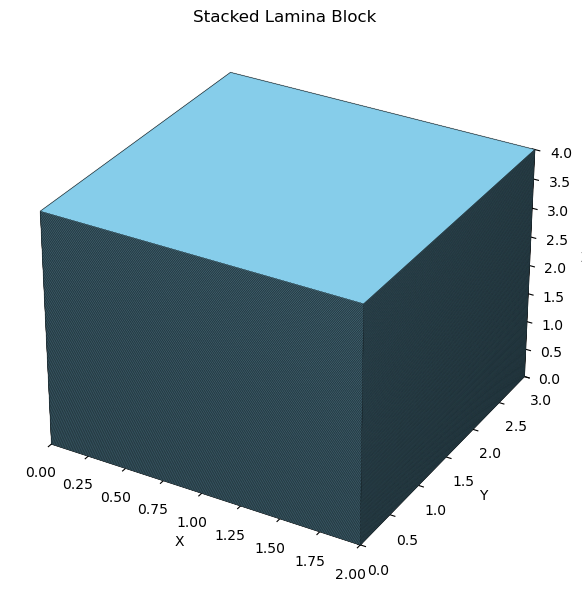

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Lamina dimensions
width = 2.0
height = 3.0
thickness = 0.01
z_start = 0.0
z_end = 4.0

# Create figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Stack laminae from z_start to z_end with given thickness
z = z_start
while z + thickness <= z_end:
    z_top = z + thickness

    # Define 8 corners of one stacked cuboid
    v0 = [0, 0, z]
    v1 = [width, 0, z]
    v2 = [width, height, z]
    v3 = [0, height, z]
    v4 = [0, 0, z_top]
    v5 = [width, 0, z_top]
    v6 = [width, height, z_top]
    v7 = [0, height, z_top]

    # 6 faces of the cuboid
    faces = [
        [v0, v1, v2, v3],  # bottom
        [v4, v5, v6, v7],  # top
        [v0, v1, v5, v4],  # front
        [v1, v2, v6, v5],  # right
        [v2, v3, v7, v6],  # back
        [v3, v0, v4, v7],  # left
    ]

    ax.add_collection3d(Poly3DCollection(faces, facecolors='skyblue', edgecolors='black', linewidths=0.2, alpha=0.9))
    z += thickness  # move to next layer

# Plot setup
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Stacked Lamina Block")

ax.set_xlim(0, width)
ax.set_ylim(0, height)#here I
ax.set_zlim(0, z_end)

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import trimesh

# Function to generate approximate Clark Y airfoil coordinates
def generate_clark_y_points(n_points=100):
    # Chord length normalized to 1
    x = np.linspace(0, 1, n_points)
    y_upper = np.zeros(n_points)
    y_lower = np.zeros(n_points)

    # Approximate Clark Y upper and lower surfaces
    # Clark Y has a flat lower surface from ~30% chord to trailing edge
    # Upper surface is cambered, approximated here with a simple curve
    for i, xi in enumerate(x):
        if xi <= 0.3:
            # Forward part: slight camber on lower surface
            y_lower[i] = -0.05 * xi  # Small negative camber
        else:
            # Flat lower surface from 30% to 100% chord
            y_lower[i] = -0.015  # Constant thickness at ~1.5% chord
        # Upper surface: parabolic approximation of camber
        y_upper[i] = 0.12 * (1 - xi) * np.sqrt(xi)  # Max thickness ~12% at 30% chord

    # Combine upper and lower surfaces
    points = np.vstack([
        np.column_stack((x, y_upper)),  # Upper surface
        np.column_stack((x[::-1], y_lower[::-1]))  # Lower surface (reversed)
    ])
    return points

# Generate airfoil coordinates
points = generate_clark_y_points(100)

# Create a closed 2D polyline for the airfoil
vertices = points
# Create edges for the polyline (connect points in order)
edges = [[i, i + 1] for i in range(len(vertices) - 1)]
edges.append([len(vertices) - 1, 0])  # Close the loop

# Create a Trimesh Path object for 2D visualization
path = trimesh.path.Path2D(entities=[trimesh.path.entities.Line(edges)], vertices=vertices)

# Optionally, extrude to create a thin 3D mesh for visualization
mesh = path.extrude(height=0.01)  # Extrude by a small amount to create a 3D mesh

# Visualize the mesh
mesh.show()



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

3D airfoil sketch saved as 'clark_y_airfoil_3d_chord_0.9229.png'.
2D airfoil sketch saved as 'clark_y_airfoil_2d_chord_0.9229.png'.


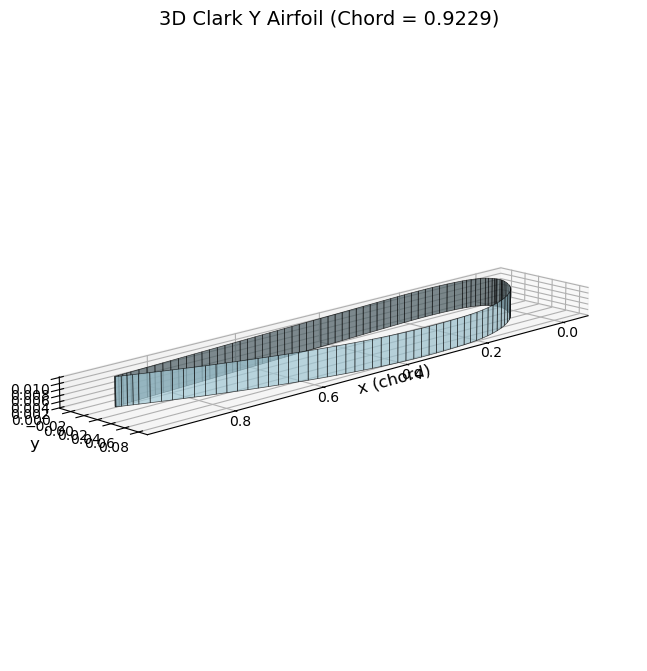

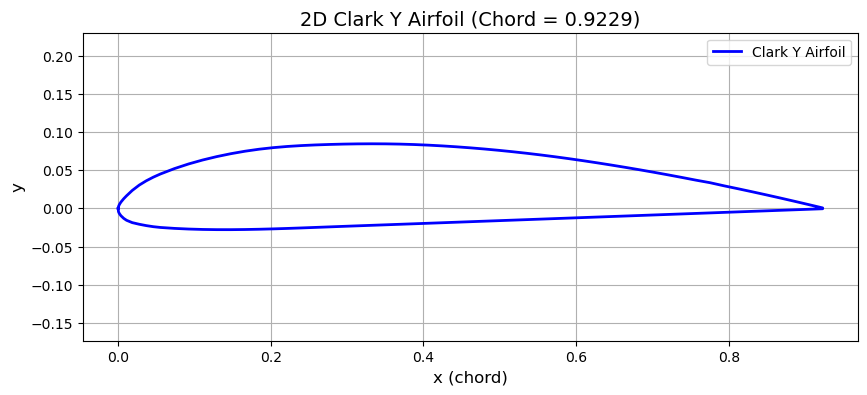

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Clark Y airfoil coordinates (upper and lower surfaces)
upper_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, 0.0023390], [0.0010000, 0.0037271], [0.0020000, 0.0058025],
    [0.0040000, 0.0089238], [0.0080000, 0.0137350], [0.0120000, 0.0178581], [0.0200000, 0.0253735],
    [0.0300000, 0.0330215], [0.0400000, 0.0391283], [0.0500000, 0.0442753], [0.0600000, 0.0487571],
    [0.0800000, 0.0564308], [0.1000000, 0.0629981], [0.1200000, 0.0686204], [0.1400000, 0.0734360],
    [0.1600000, 0.0775707], [0.1800000, 0.0810687], [0.2000000, 0.0839202], [0.2200000, 0.0861433],
    [0.2400000, 0.0878308], [0.2600000, 0.0890840], [0.2800000, 0.0900016], [0.3000000, 0.0906804],
    [0.3200000, 0.0911857], [0.3400000, 0.0915079], [0.3600000, 0.0916266], [0.3800000, 0.0915212],
    [0.4000000, 0.0911712], [0.4200000, 0.0905657], [0.4400000, 0.0897175], [0.4600000, 0.0886427],
    [0.4800000, 0.0873572], [0.5000000, 0.0858772], [0.5200000, 0.0842145], [0.5400000, 0.0823712],
    [0.5600000, 0.0803480], [0.5800000, 0.0781456], [0.6000000, 0.0757633], [0.6200000, 0.0732055],
    [0.6400000, 0.0704822], [0.6600000, 0.0676046], [0.6800000, 0.0645843], [0.7000000, 0.0614329],
    [0.7200000, 0.0581599], [0.7400000, 0.0547675], [0.7600000, 0.0512565], [0.7800000, 0.0476281],
    [0.8000000, 0.0438836], [0.8200000, 0.0400245], [0.8400000, 0.036416], [0.8600000, 0.0319740],
    [0.8800000, 0.0277891], [0.9000000, 0.0235025], [0.9200000, 0.0191156], [0.9400000, 0.0146239],
    [0.9600000, 0.0100232], [0.9700000, 0.0076868], [0.9800000, 0.0053335], [0.9900000, 0.0029690],
    [1.0000000, 0.0005993]
])

lower_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, -0.0046700], [0.0010000, -0.0059418], [0.0020000, -0.0078113],
    [0.0040000, -0.0105126], [0.0080000, -0.0142862], [0.0120000, -0.0169733], [0.0200000, -0.0202723],
    [0.0300000, -0.0226056], [0.0400000, -0.0245211], [0.0500000, -0.0260452], [0.0600000, -0.0271277],
    [0.0800000, -0.0284595], [0.1000000, -0.0293786], [0.1200000, -0.0299633], [0.1400000, -0.0302404],
    [0.1600000, -0.0302546], [0.1800000, -0.0300490], [0.2000000, -0.0296656], [0.2200000, -0.0291445],
    [0.2400000, -0.0285181], [0.2600000, -0.0278164], [0.2800000, -0.0270696], [0.3000000, -0.0263079],
    [0.3200000, -0.0255565], [0.3400000, -0.0248176], [0.3600000, -0.0240870], [0.3800000, -0.0233606],
    [0.4000000, -0.0226341], [0.4200000, -0.0219042], [0.4400000, -0.0211708], [0.4600000, -0.0204353],
    [0.4800000, -0.0196986], [0.5000000, -0.0189619], [0.5200000, -0.0182262], [0.5400000, -0.0174914],
    [0.5600000, -0.0167572], [0.5800000, -0.0160232], [0.6000000, -0.0152893], [0.6200000, -0.0145551],
    [0.6400000, -0.0138207], [0.6600000, -0.0130862], [0.6800000, -0.0123515], [0.7000000, -0.0116169],
    [0.7200000, -0.0108823], [0.7400000, -0.0101478], [0.7600000, -0.0094133], [0.7800000, -0.0086788],
    [0.8000000, -0.0079443], [0.8200000, -0.0072098], [0.8400000, -0.0064753], [0.8600000, -0.0057408],
    [0.8800000, -0.0050063], [0.9000000, -0.0042718], [0.9200000, -0.0035373], [0.9400000, -0.0028028],
    [0.9600000, -0.0020683], [0.9700000, -0.0017011], [0.9800000, -0.0013339], [0.9900000, -0.0009666],
    [1.0000000, -0.0005993]
])

# Scale coordinates to chord length of 0.9229
chord_length = 0.9229
upper_surface *= chord_length
lower_surface *= chord_length

# Combine upper and lower surfaces to form a closed loop
points = np.vstack([upper_surface, lower_surface[::-1]])  # Reverse lower surface for continuity

# Extrude the airfoil along z-axis for 3D visualization
z_span = 0.01  # Thin extrusion for realistic airfoil
X = np.vstack([points[:, 0], points[:, 0]])  # Duplicate x for front and back faces
Y = np.vstack([points[:, 1], points[:, 1]])  # Duplicate y for front and back faces
Z = np.vstack([np.zeros(len(points)), np.ones(len(points)) * z_span])  # z from 0 to z_span

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the airfoil surface with improved styling
ax.plot_surface(X, Y, Z, color='lightblue', alpha=0.7, rstride=1, cstride=1, edgecolor='black', linewidth=0.5)

# Set labels and title with better formatting
ax.set_xlabel('x (chord)', fontsize=12, labelpad=10)
ax.set_ylabel('y', fontsize=12, labelpad=10)
ax.set_zlabel('z (extruded)', fontsize=12, labelpad=10)
ax.set_title('3D Clark Y Airfoil (Chord = 0.9229)', fontsize=14, pad=15)

# Adjust view angle for optimal visibility
ax.view_init(elev=15, azim=45)

# Set aspect ratio to make airfoil look proportional
ax.set_box_aspect([1, 0.2, 0.05])  # Compress y and z for thin, realistic look

# Add grid for better context
ax.grid(True)

# Save the 3D plot
plt.savefig('clark_y_airfoil_3d_chord_0.9229.png', dpi=300, bbox_inches='tight')
print("3D airfoil sketch saved as 'clark_y_airfoil_3d_chord_0.9229.png'.")

# Create a 2D plot for reference
fig_2d = plt.figure(figsize=(10, 4))
plt.plot(points[:, 0], points[:, 1], 'b-', linewidth=2, label='Clark Y Airfoil')
plt.axis('equal')
plt.xlabel('x (chord)', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('2D Clark Y Airfoil (Chord = 0.9229)', fontsize=14)
plt.grid(True)
plt.legend()
print("2D airfoil sketch saved as 'clark_y_airfoil_2d_chord_0.9229.png'.")

# Display both plots
plt.show()

AttributeError: module 'numpy' has no attribute 'arr'

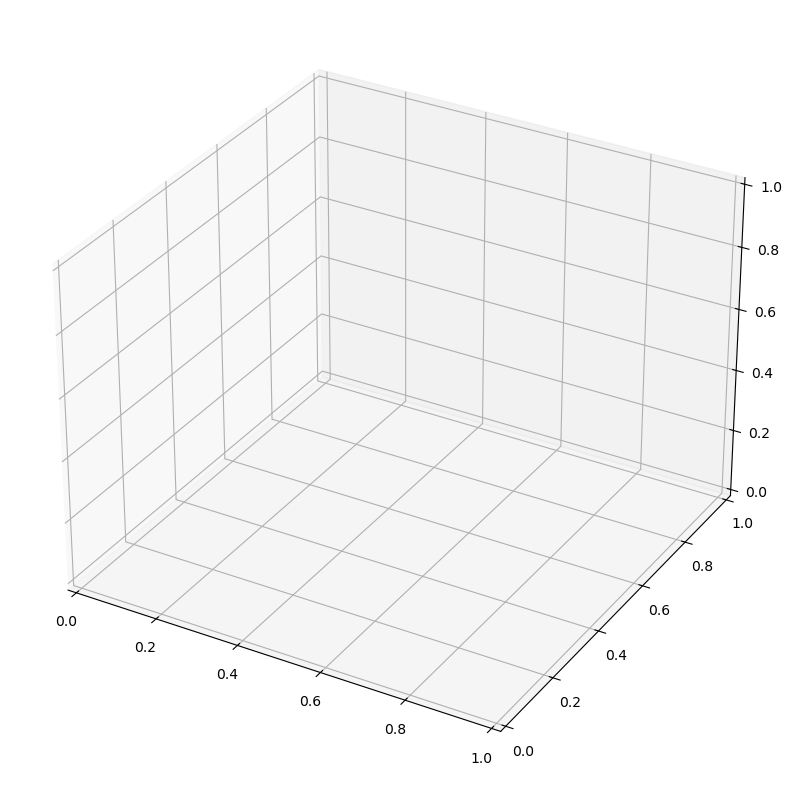

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Clark Y airfoil coordinates (upper and lower surfaces)
upper_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, 0.0023390], [0.0010000, 0.0037271], [0.0020000, 0.0058025],
    [0.0040000, 0.0089238], [0.0080000, 0.0137350], [0.0120000, 0.0178581], [0.0200000, 0.0253735],
    [0.0300000, 0.0330215], [0.0400000, 0.0391283], [0.0500000, 0.0442753], [0.0600000, 0.0487571],
    [0.0800000, 0.0564308], [0.1000000, 0.0629981], [0.1200000, 0.0686204], [0.1400000, 0.0734360],
    [0.1600000, 0.0775707], [0.1800000, 0.0810687], [0.2000000, 0.0839202], [0.2200000, 0.0861433],
    [0.2400000, 0.0878308], [0.2600000, 0.0890840], [0.2800000, 0.0900016], [0.3000000, 0.0906804],
    [0.3200000, 0.0911857], [0.3400000, 0.0915079], [0.3600000, 0.0916266], [0.3800000, 0.0915212],
    [0.4000000, 0.0911712], [0.4200000, 0.0905657], [0.4400000, 0.0897175], [0.4600000, 0.0886427],
    [0.4800000, 0.0873572], [0.5000000, 0.0858772], [0.5200000, 0.0842145], [0.5400000, 0.0823712],
    [0.5600000, 0.0803480], [0.5800000, 0.0781456], [0.6000000, 0.0757633], [0.6200000, 0.0732055],
    [0.6400000, 0.0704822], [0.6600000, 0.0676046], [0.6800000, 0.0645843], [0.7000000, 0.0614329],
    [0.7200000, 0.0581599], [0.7400000, 0.0547675], [0.7600000, 0.0512565], [0.7800000, 0.0476281],
    [0.8000000, 0.0438836], [0.8200000, 0.0400245], [0.8400000, 0.036416], [0.8600000, 0.0319740],
    [0.8800000, 0.0277891], [0.9000000, 0.0235025], [0.9200000, 0.0191156], [0.9400000, 0.0146239],
    [0.9600000, 0.0100232], [0.9700000, 0.0076868], [0.9800000, 0.0053335], [0.9900000, 0.0029690],
    [1.0000000, 0.0005993]
])

lower_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, -0.0046700], [0.0010000, -0.0059418], [0.0020000, -0.0078113],
    [0.0040000, -0.0105126], [0.0080000, -0.0142862], [0.0120000, -0.0169733], [0.0200000, -0.0202723],
    [0.0300000, -0.0226056], [0.0400000, -0.0245211], [0.0500000, -0.0260452], [0.0600000, -0.0271277],
    [0.0800000, -0.0284595], [0.1000000, -0.0293786], [0.1200000, -0.0299633], [0.1400000, -0.0302404],
    [0.1600000, -0.0302546], [0.1800000, -0.0300490], [0.2000000, -0.0296656], [0.2200000, -0.0291445],
    [0.2400000, -0.0285181], [0.2600000, -0.0278164], [0.2800000, -0.0270696], [0.3000000, -0.0263079],
    [0.3200000, -0.0255565], [0.3400000, -0.0248176], [0.3600000, -0.0240870], [0.3800000, -0.0233606],
    [0.4000000, -0.0226341], [0.4200000, -0.0219042], [0.4400000, -0.0211708], [0.4600000, -0.0204353],
    [0.4800000, -0.0196986], [0.5000000, -0.0189619], [0.5200000, -0.0182262], [0.5400000, -0.0174914],
    [0.5600000, -0.0167572], [0.5800000, -0.0160232], [0.6000000, -0.0152893], [0.6200000, -0.0145551],
    [0.6400000, -0.0138207], [0.6600000, -0.0130862], [0.6800000, -0.0123515], [0.7000000, -0.0116169],
    [0.7200000, -0.0108823], [0.7400000, -0.0101478], [0.7600000, -0.0094133], [0.7800000, -0.0086788],
    [0.8000000, -0.0079443], [0.8200000, -0.0072098], [0.8400000, -0.0064753], [0.8600000, -0.0057408],
    [0.8800000, -0.0050063], [0.9000000, -0.0042718], [0.9200000, -0.0035373], [0.9400000, -0.0028028],
    [0.9600000, -0.0020683], [0.9700000, -0.0017011], [0.9800000, -0.0013339], [0.9900000, -0.0009666],
    [1.0000000, -0.0005993]
])

# Scale coordinates to chord length
chord_length = 0.9229
upper_surface *= chord_length
lower_surface *= chord_length

# Combine upper and lower surfaces to form a closed loop
airfoil_profile = np.vstack([upper_surface, lower_surface[::-1]])

# Block parameters
block_height = 0.7089
z_bottom = 0.0
z_top = block_height

# Create 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create mesh grids for the airfoil surfaces
n_points = len(airfoil_profile)
z_levels = np.array([z_bottom, z_top])

# Create X, Y, Z coordinates for the surfaces
X = np.array([airfoil_profile[:, 0], airfoil_profile[:, 0]])
Y = np.array([airfoil_profile[:, 1], airfoil_profile[:, 1]])
Z = np.arr

2D airfoil sketch saved as 'clark_y_airfoil_2d.png'.


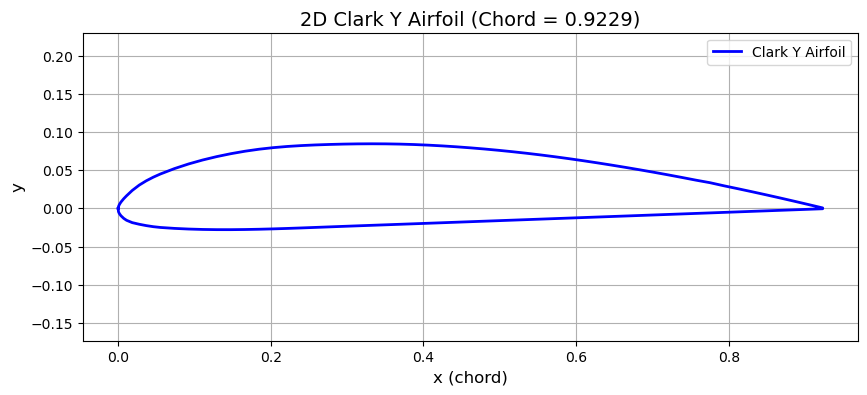

In [25]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Clark Y airfoil coordinates (upper and lower surfaces)
upper_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, 0.0023390], [0.0010000, 0.0037271], [0.0020000, 0.0058025],
    [0.0040000, 0.0089238], [0.0080000, 0.0137350], [0.0120000, 0.0178581], [0.0200000, 0.0253735],
    [0.0300000, 0.0330215], [0.0400000, 0.0391283], [0.0500000, 0.0442753], [0.0600000, 0.0487571],
    [0.0800000, 0.0564308], [0.1000000, 0.0629981], [0.1200000, 0.0686204], [0.1400000, 0.0734360],
    [0.1600000, 0.0775707], [0.1800000, 0.0810687], [0.2000000, 0.0839202], [0.2200000, 0.0861433],
    [0.2400000, 0.0878308], [0.2600000, 0.0890840], [0.2800000, 0.0900016], [0.3000000, 0.0906804],
    [0.3200000, 0.0911857], [0.3400000, 0.0915079], [0.3600000, 0.0916266], [0.3800000, 0.0915212],
    [0.4000000, 0.0911712], [0.4200000, 0.0905657], [0.4400000, 0.0897175], [0.4600000, 0.0886427],
    [0.4800000, 0.0873572], [0.5000000, 0.0858772], [0.5200000, 0.0842145], [0.5400000, 0.0823712],
    [0.5600000, 0.0803480], [0.5800000, 0.0781456], [0.6000000, 0.0757633], [0.6200000, 0.0732055],
    [0.6400000, 0.0704822], [0.6600000, 0.0676046], [0.6800000, 0.0645843], [0.7000000, 0.0614329],
    [0.7200000, 0.0581599], [0.7400000, 0.0547675], [0.7600000, 0.0512565], [0.7800000, 0.0476281],
    [0.8000000, 0.0438836], [0.8200000, 0.0400245], [0.8400000, 0.036416], [0.8600000, 0.0319740],
    [0.8800000, 0.0277891], [0.9000000, 0.0235025], [0.9200000, 0.0191156], [0.9400000, 0.0146239],
    [0.9600000, 0.0100232], [0.9700000, 0.0076868], [0.9800000, 0.0053335], [0.9900000, 0.0029690],
    [1.0000000, 0.0005993]
])

lower_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, -0.0046700], [0.0010000, -0.0059418], [0.0020000, -0.0078113],
    [0.0040000, -0.0105126], [0.0080000, -0.0142862], [0.0120000, -0.0169733], [0.0200000, -0.0202723],
    [0.0300000, -0.0226056], [0.0400000, -0.0245211], [0.0500000, -0.0260452], [0.0600000, -0.0271277],
    [0.0800000, -0.0284595], [0.1000000, -0.0293786], [0.1200000, -0.0299633], [0.1400000, -0.0302404],
    [0.1600000, -0.0302546], [0.1800000, -0.0300490], [0.2000000, -0.0296656], [0.2200000, -0.0291445],
    [0.2400000, -0.0285181], [0.2600000, -0.0278164], [0.2800000, -0.0270696], [0.3000000, -0.0263079],
    [0.3200000, -0.0255565], [0.3400000, -0.0248176], [0.3600000, -0.0240870], [0.3800000, -0.0233606],
    [0.4000000, -0.0226341], [0.4200000, -0.0219042], [0.4400000, -0.0211708], [0.4600000, -0.0204353],
    [0.4800000, -0.0196986], [0.5000000, -0.0189619], [0.5200000, -0.0182262], [0.5400000, -0.0174914],
    [0.5600000, -0.0167572], [0.5800000, -0.0160232], [0.6000000, -0.0152893], [0.6200000, -0.0145551],
    [0.6400000, -0.0138207], [0.6600000, -0.0130862], [0.6800000, -0.0123515], [0.7000000, -0.0116169],
    [0.7200000, -0.0108823], [0.7400000, -0.0101478], [0.7600000, -0.0094133], [0.7800000, -0.0086788],
    [0.8000000, -0.0079443], [0.8200000, -0.0072098], [0.8400000, -0.0064753], [0.8600000, -0.0057408],
    [0.8800000, -0.0050063], [0.9000000, -0.0042718], [0.9200000, -0.0035373], [0.9400000, -0.0028028],
    [0.9600000, -0.0020683], [0.9700000, -0.0017011], [0.9800000, -0.0013339], [0.9900000, -0.0009666],
    [1.0000000, -0.0005993]
])

# Scale coordinates to chord length of 0.9229
chord_length = 0.9229
upper_surface *= chord_length
lower_surface *= chord_length

# Combine upper and lower surfaces to form a closed loop
points = np.vstack([upper_surface, lower_surface[::-1]])  # Reverse lower surface for continuity

# Stacking parameters
z_span = 0.01  # Thickness of each airfoil
spacing = 0.01  # Spacing between airfoils
total_height = 0.7089  # Total station distance
airfoil_height = z_span + spacing  # Total z-height per airfoil
num_airfoils = int(total_height / airfoil_height)  # Number of airfoils (35)

# Create Plotly figure
fig = go.Figure()

# Plot each stacked airfoil
for i in range(num_airfoils):
    z_offset = i * airfoil_height  # Starting z-position
    X = np.vstack([points[:, 0], points[:, 0]])  # Duplicate x for front and back
    Y = np.vstack([points[:, 1], points[:, 1]])  # Duplicate y for front and back
    Z = np.vstack([np.zeros(len(points)) + z_offset, np.ones(len(points)) * z_span + z_offset])  # z range

    # Add surface plot
    fig.add_trace(go.Surface(
        x=X, y=Y, z=Z,
        colorscale='Blues',
        opacity=0.7,
        showscale=False,
        name=f'Airfoil {i+1}'
    ))

# Update layout for better appearance
fig.update_layout(
    title=f'Stacked Clark Y Airfoil (Chord = 0.9229, Height = {total_height})',
    scene=dict(
        xaxis_title='x (chord)',
        yaxis_title='y',
        zaxis_title='z (stacked)',
        aspectratio=dict(x=1, y=0.2, z=0.5),  # Adjusted for stacked airfoils
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.0)  # Adjusted camera for clear view
        )
    ),
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50)
)


# Create a 2D Matplotlib plot for reference (single airfoil)
plt.figure(figsize=(10, 4))
plt.plot(points[:, 0], points[:, 1], 'b-', linewidth=2, label='Clark Y Airfoil')
plt.axis('equal')
plt.xlabel('x (chord)', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('2D Clark Y Airfoil (Chord = 0.9229)', fontsize=14)
plt.grid(True)
plt.legend()
print("2D airfoil sketch saved as 'clark_y_airfoil_2d.png'.")
plt.show()

In [27]:
import numpy as np
import trimesh

# Clark Y airfoil coordinates (upper and lower surfaces)
upper_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, 0.0023390], [0.0010000, 0.0037271], [0.0020000, 0.0058025],
    [0.0040000, 0.0089238], [0.0080000, 0.0137350], [0.0120000, 0.0178581], [0.0200000, 0.0253735],
    [0.0300000, 0.0330215], [0.0400000, 0.0391283], [0.0500000, 0.0442753], [0.0600000, 0.0487571],
    [0.0800000, 0.0564308], [0.1000000, 0.0629981], [0.1200000, 0.0686204], [0.1400000, 0.0734360],
    [0.1600000, 0.0775707], [0.1800000, 0.0810687], [0.2000000, 0.0839202], [0.2200000, 0.0861433],
    [0.2400000, 0.0878308], [0.2600000, 0.0890840], [0.2800000, 0.0900016], [0.3000000, 0.0906804],
    [0.3200000, 0.0911857], [0.3400000, 0.0915079], [0.3600000, 0.0916266], [0.3800000, 0.0915212],
    [0.4000000, 0.0911712], [0.4200000, 0.0905657], [0.4400000, 0.0897175], [0.4600000, 0.0886427],
    [0.4800000, 0.0873572], [0.5000000, 0.0858772], [0.5200000, 0.0842145], [0.5400000, 0.0823712],
    [0.5600000, 0.0803480], [0.5800000, 0.0781456], [0.6000000, 0.0757633], [0.6200000, 0.0732055],
    [0.6400000, 0.0704822], [0.6600000, 0.0676046], [0.6800000, 0.0645843], [0.7000000, 0.0614329],
    [0.7200000, 0.0581599], [0.7400000, 0.0547675], [0.7600000, 0.0512565], [0.7800000, 0.0476281],
    [0.8000000, 0.0438836], [0.8200000, 0.0400245], [0.8400000, 0.036416], [0.8600000, 0.0319740],
    [0.8800000, 0.0277891], [0.9000000, 0.0235025], [0.9200000, 0.0191156], [0.9400000, 0.0146239],
    [0.9600000, 0.0100232], [0.9700000, 0.0076868], [0.9800000, 0.0053335], [0.9900000, 0.0029690],
    [1.0000000, 0.0005993]
])

lower_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, -0.0046700], [0.0010000, -0.0059418], [0.0020000, -0.0078113],
    [0.0040000, -0.0105126], [0.0080000, -0.0142862], [0.0120000, -0.0169733], [0.0200000, -0.0202723],
    [0.0300000, -0.0226056], [0.0400000, -0.0245211], [0.0500000, -0.0260452], [0.0600000, -0.0271277],
    [0.0800000, -0.0284595], [0.1000000, -0.0293786], [0.1200000, -0.0299633], [0.1400000, -0.0302404],
    [0.1600000, -0.0302546], [0.1800000, -0.0300490], [0.2000000, -0.0296656], [0.2200000, -0.0291445],
    [0.2400000, -0.0285181], [0.2600000, -0.0278164], [0.2800000, -0.0270696], [0.3000000, -0.0263079],
    [0.3200000, -0.0255565], [0.3400000, -0.0248176], [0.3600000, -0.0240870], [0.3800000, -0.0233606],
    [0.4000000, -0.0226341], [0.4200000, -0.0219042], [0.4400000, -0.0211708], [0.4600000, -0.0204353],
    [0.4800000, -0.0196986], [0.5000000, -0.0189619], [0.5200000, -0.0182262], [0.5400000, -0.0174914],
    [0.5600000, -0.0167572], [0.5800000, -0.0160232], [0.6000000, -0.0152893], [0.6200000, -0.0145551],
    [0.6400000, -0.0138207], [0.6600000, -0.0130862], [0.6800000, -0.0123515], [0.7000000, -0.0116169],
    [0.7200000, -0.0108823], [0.7400000, -0.0101478], [0.7600000, -0.0094133], [0.7800000, -0.0086788],
    [0.8000000, -0.0079443], [0.8200000, -0.0072098], [0.8400000, -0.0064753], [0.8600000, -0.0057408],
    [0.8800000, -0.0050063], [0.9000000, -0.0042718], [0.9200000, -0.0035373], [0.9400000, -0.0028028],
    [0.9600000, -0.0020683], [0.9700000, -0.0017011], [0.9800000, -0.0013339], [0.9900000, -0.0009666],
    [1.0000000, -0.0005993]
])

# Scale coordinates to chord length of 0.9229
chord_length = 0.9229
upper_surface *= chord_length
lower_surface *= chord_length

# Combine upper and lower surfaces to form a closed loop
points = np.vstack([upper_surface, lower_surface[::-1]])

# Stacking parameters
total_height = 0.7089
num_airfoils = 35
layer_thickness = total_height / num_airfoils  # Extrusion thickness per airfoil
twist_angle = -32.8153 * np.pi / 180  # Convert to radians (clockwise)

# Create rotation matrix function
def rotation_matrix_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

# Create a list to store meshes
meshes = []

# Generate and stack airfoils
for i in range(num_airfoils):
    # Apply twist
    theta = i * twist_angle
    R = rotation_matrix_z(theta)
    rotated_points = np.dot(points, R[:2, :2])  # Rotate x, y coordinates

    # Create vertices for Trimesh (add z-coordinate)
    z_offset = i * layer_thickness
    vertices_2d = np.hstack([rotated_points, np.zeros((len(rotated_points), 1))])
    vertices_2d[:, 2] = z_offset  # Set z to base of layer

    # Create edges for closed loop
    edges = [[j, (j + 1) % len(rotated_points)] for j in range(len(rotated_points))]

    # Create Path2D and extrude
    try:
        path = trimesh.path.Path2D(entities=[trimesh.path.entities.Line(e) for e in edges], vertices=vertices_2d)
        mesh = path.extrude(height=layer_thickness)
        meshes.append(mesh)
    except Exception as e:
        print(f"Error creating mesh for layer {i}: {e}")
        continue

# Combine meshes into a single solid block
if meshes:
    try:
        combined_mesh = trimesh.util.concatenate(meshes)
        
        # Visualize the mesh
        try:
            combined_mesh.show()
        except Exception as e:
            print(f"Visualization failed: {e}. Try running in an environment with OpenGL support.")
    except Exception as e:
        print(f"Error combining meshes: {e}")
else:
    print("No meshes were created.")

Error combining meshes: The second dimension of vertices is not 2!


In [29]:
import numpy as np
import trimesh

upper_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, 0.0023390], [0.0010000, 0.0037271], [0.0020000, 0.0058025],
    [0.0040000, 0.0089238], [0.0080000, 0.0137350], [0.0120000, 0.0178581], [0.0200000, 0.0253735],
    [0.0300000, 0.0330215], [0.0400000, 0.0391283], [0.0500000, 0.0442753], [0.0600000, 0.0487571],
    [0.0800000, 0.0564308], [0.1000000, 0.0629981], [0.1200000, 0.0686204], [0.1400000, 0.0734360],
    [0.1600000, 0.0775707], [0.1800000, 0.0810687], [0.2000000, 0.0839202], [0.2200000, 0.0861433],
    [0.2400000, 0.0878308], [0.2600000, 0.0890840], [0.2800000, 0.0900016], [0.3000000, 0.0906804],
    [0.3200000, 0.0911857], [0.3400000, 0.0915079], [0.3600000, 0.0916266], [0.3800000, 0.0915212],
    [0.4000000, 0.0911712], [0.4200000, 0.0905657], [0.4400000, 0.0897175], [0.4600000, 0.0886427],
    [0.4800000, 0.0873572], [0.5000000, 0.0858772], [0.5200000, 0.0842145], [0.5400000, 0.0823712],
    [0.5600000, 0.0803480], [0.5800000, 0.0781456], [0.6000000, 0.0757633], [0.6200000, 0.0732055],
    [0.6400000, 0.0704822], [0.6600000, 0.0676046], [0.6800000, 0.0645843], [0.7000000, 0.0614329],
    [0.7200000, 0.0581599], [0.7400000, 0.0547675], [0.7600000, 0.0512565], [0.7800000, 0.0476281],
    [0.8000000, 0.0438836], [0.8200000, 0.0400245], [0.8400000, 0.036416], [0.8600000, 0.0319740],
    [0.8800000, 0.0277891], [0.9000000, 0.0235025], [0.9200000, 0.0191156], [0.9400000, 0.0146239],
    [0.9600000, 0.0100232], [0.9700000, 0.0076868], [0.9800000, 0.0053335], [0.9900000, 0.0029690],
    [1.0000000, 0.0005993]
])

lower_surface = np.array([
    [0.0000000, 0.0000000], [0.0005000, -0.0046700], [0.0010000, -0.0059418], [0.0020000, -0.0078113],
    [0.0040000, -0.0105126], [0.0080000, -0.0142862], [0.0120000, -0.0169733], [0.0200000, -0.0202723],
    [0.0300000, -0.0226056], [0.0400000, -0.0245211], [0.0500000, -0.0260452], [0.0600000, -0.0271277],
    [0.0800000, -0.0284595], [0.1000000, -0.0293786], [0.1200000, -0.0299633], [0.1400000, -0.0302404],
    [0.1600000, -0.0302546], [0.1800000, -0.0300490], [0.2000000, -0.0296656], [0.2200000, -0.0291445],
    [0.2400000, -0.0285181], [0.2600000, -0.0278164], [0.2800000, -0.0270696], [0.3000000, -0.0263079],
    [0.3200000, -0.0255565], [0.3400000, -0.0248176], [0.3600000, -0.0240870], [0.3800000, -0.0233606],
    [0.4000000, -0.0226341], [0.4200000, -0.0219042], [0.4400000, -0.0211708], [0.4600000, -0.0204353],
    [0.4800000, -0.0196986], [0.5000000, -0.0189619], [0.5200000, -0.0182262], [0.5400000, -0.0174914],
    [0.5600000, -0.0167572], [0.5800000, -0.0160232], [0.6000000, -0.0152893], [0.6200000, -0.0145551],
    [0.6400000, -0.0138207], [0.6600000, -0.0130862], [0.6800000, -0.0123515], [0.7000000, -0.0116169],
    [0.7200000, -0.0108823], [0.7400000, -0.0101478], [0.7600000, -0.0094133], [0.7800000, -0.0086788],
    [0.8000000, -0.0079443], [0.8200000, -0.0072098], [0.8400000, -0.0064753], [0.8600000, -0.0057408],
    [0.8800000, -0.0050063], [0.9000000, -0.0042718], [0.9200000, -0.0035373], [0.9400000, -0.0028028],
    [0.9600000, -0.0020683], [0.9700000, -0.0017011], [0.9800000, -0.0013339], [0.9900000, -0.0009666],
    [1.0000000, -0.0005993]
])
# Scale coordinates to chord length of 0.9229
chord_length = 0.9229
upper_surface *= chord_length
lower_surface *= chord_length

# Combine upper and lower surfaces to form a closed loop
points = np.vstack([upper_surface, lower_surface[::-1]])

# Stacking parameters
total_height = 0.7089
num_airfoils = 35
layer_thickness = total_height / num_airfoils  # Extrusion thickness per airfoil (~0.020254)
twist_angle = -32.8153 * np.pi / 180  # Convert to radians (clockwise)

# Create rotation matrix function
def rotation_matrix_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

# Create a list to store meshes
meshes = []

# Generate and stack airfoils
for i in range(num_airfoils):
    # Apply twist
    theta = i * twist_angle
    R = rotation_matrix_z(theta)
    rotated_points = np.dot(points, R[:2, :2])  # Rotate x, y coordinates (2D)

    # Create 2D vertices for Path2D (x, y only)
    vertices_2d = rotated_points

    # Create edges for closed loop
    edges = [[j, (j + 1) % len(rotated_points)] for j in range(len(rotated_points))]

    # Create Path2D and extrude
    try:
        path = trimesh.path.Path2D(entities=[trimesh.path.entities.Line(e) for e in edges], vertices=vertices_2d)
        # Extrude with z-offset
        mesh = path.extrude(height=layer_thickness)
        # Translate mesh to correct z-position
        mesh.apply_translation([0, 0, i * layer_thickness])
        meshes.append(mesh)
    except Exception as e:
        print(f"Error creating mesh for layer {i}: {e}")
        continue

# Combine meshes into a single solid block
if meshes:
    try:
        combined_mesh = trimesh.util.concatenate(meshes)
        
        # Visualize the mesh
        try:
            combined_mesh.show()
            print("Interactive 3D solid airfoil stack displayed. Rotate, zoom, and pan with the mouse.")
        except Exception as e:
            print(f"Visualization failed: {e}. Try running in an environment with OpenGL support or use MeshLab/Blender to view a saved STL.")
    except Exception as e:
        print(f"Error combining meshes: {e}")
else:
    print("No meshes were created.")

Interactive 3D solid airfoil stack displayed. Rotate, zoom, and pan with the mouse.


In [36]:
import os
import re

folder_path = "PE0-FILES_WEB"
airfoil1_set = set()

for filename in os.listdir(folder_path):
    if filename.lower().endswith(".peo"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            lines = file.readlines()
            in_airfoil_section = False

            for line in lines:
                line = line.strip()

                # Activate flag when we hit the section
                if "----- AIRFOIL SECTIONS -----" in line:
                    in_airfoil_section = True
                    continue

                if in_airfoil_section and line.upper().startswith("AIRFOIL1:"):
                    # Extract all tokens after colon
                    parts = line.split(":")
                    if len(parts) < 2:
                        break
                    rest = parts[1]

                    # Split rest by comma
                    tokens = rest.split(',')
                    if len(tokens) < 2:
                        break

                    # Extract the airfoil name: first token in second part that starts with a letter
                    after_comma = tokens[1].strip().split()
                    for token in after_comma:
                        if token[0].isalpha():
                            airfoil1_set.add(token.upper())  # optional .upper() to normalize
                            break
                    break  # stop after AIRFOIL1

# Output result
print("Unique AIRFOIL1 names found:", len(airfoil1_set))
print("List of unique AIRFOIL1 airfoils:")
for airfoil in sorted(airfoil1_set):
    print(airfoil)


Unique AIRFOIL1 names found: 0
List of unique AIRFOIL1 airfoils:
